In [1]:
import sys
sys.path.append("../")
from pathlib import Path

DIR = Path("/data1/xp/code/specEmbedding/score_distribution/pair")

import torch
from torch.utils.data import DataLoader
import numpy as np
from model import MSBERT

from utils import ModelEmbed, cosine_similarity, get_labels, eq
from const import gnps
from type import TokenizerConfig
from data import Tokenizer, TokenSequenceDataset

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_state_path = "/data1/xp/data/MSBert/MSBERT.pkl"
model_state = torch.load(model_state_path)

model = MSBERT(
    100002,
    512,
    6,
    16,
    0,
    100,
    3
)
model.load_state_dict(model_state)
model = model.to(device)

show_progress_bar = False
tokenizer_config = TokenizerConfig(
    max_len=100,
    n_decimals=2,
    show_progress_bar=show_progress_bar
)
tokenizer = Tokenizer(**tokenizer_config)

In [3]:
spectra = np.load(gnps.ORBITRAP_TEST_QUERY, allow_pickle=True)

sequences = tokenizer.tokenize_sequence(spectra)
dataset = TokenSequenceDataset(sequences)
loader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=False
)

spectra_embedding = ModelEmbed(model, loader, device)
cosine_scores = cosine_similarity(spectra_embedding, spectra_embedding)
mask = np.diag(np.ones((cosine_scores.shape[0]))).astype(bool)
mask = ~mask
cosine_scores = cosine_scores[mask]
np.save("/data1/xp/code/specEmbedding/score_distribution/tanimoto/MSBERT.npy", cosine_scores.flatten())

In [4]:
query_spectra = np.load(gnps.ORBITRAP_TEST_QUERY, allow_pickle=True)
ref_spectra = np.load(gnps.ORBITRAP_TEST_REF, allow_pickle=True)

query_smiles = np.array([
    s.get("smiles")
    for s in query_spectra
])
ref_smiles = np.array([
    s.get("smiles")
    for s in ref_spectra
])
query_sequences = tokenizer.tokenize_sequence(query_spectra)
ref_sequences = tokenizer.tokenize_sequence(ref_spectra)
query_dataset = TokenSequenceDataset(query_sequences)
ref_dataset = TokenSequenceDataset(ref_sequences)

ref_loader = DataLoader(
    ref_dataset,
    batch_size=512,
    shuffle=False
)
query_loader = DataLoader(
    query_dataset,
    batch_size=512,
    shuffle=False
)

ref_embedding = ModelEmbed(model, ref_loader, device)
query_embedding = ModelEmbed(model, query_loader, device)

cosine_scores = cosine_similarity(query_embedding, ref_embedding)
positive_indices = np.load(DIR / "positive_indices.npy", allow_pickle=True).item()
negative_indices = np.load(DIR / "negative_indices.npy", allow_pickle=True).item()

data = {
    "positive": cosine_scores[positive_indices["row"], positive_indices["col"]],
    "negative": cosine_scores[negative_indices["row"], negative_indices["col"]]
}

np.save(DIR / "MSBERT.npy", data)

<Axes: ylabel='Density'>

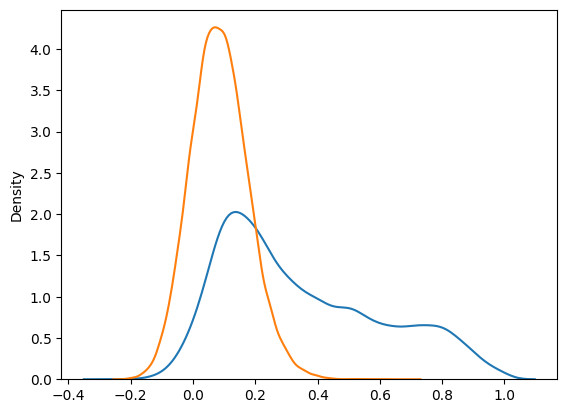

In [5]:
import seaborn as sns

sns.kdeplot(data["positive"])
sns.kdeplot(data["negative"])